# Back to basics
tests in `metallicity model recovery tests.ipynb` and `metallicity model recovery tests2.ipynb` suggests that there might be hidden inconsistancies/biases within bagpipes, that cause the biased posteriors in Mstar, fburst, etc. Going back to basics, here we try to put Bagpipes to test recovering some simpler SFH models, and slowly build up

In [15]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../../..')
from code_bits.fitting import *

3623.3599 7799.9995


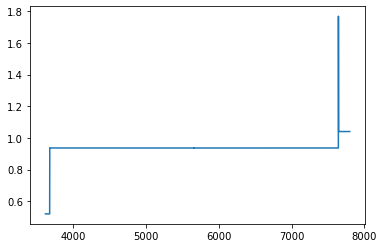

In [2]:
# load in Yirui's mock spectra for wavelength grid
spectrum = np.loadtxt(fname='../../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                      "2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test"+".csv", 
                      delimiter=',', skiprows=1)
# only want the range that is fitted normally
obs_wavs = spectrum[:,0][np.where((spectrum[:,0]>3623) & (spectrum[:,0]<7500*(1+0.04)))]
print(min(obs_wavs), max(obs_wavs))
plt.plot(obs_wavs[:-1], np.diff(obs_wavs))

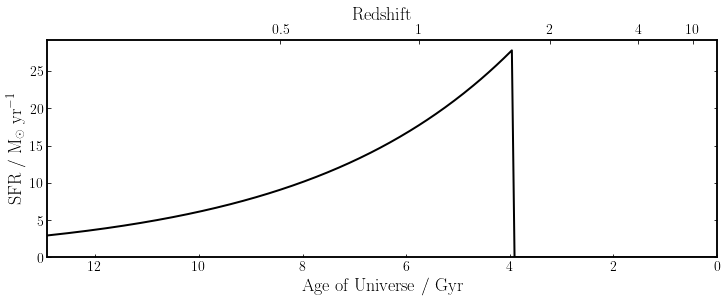

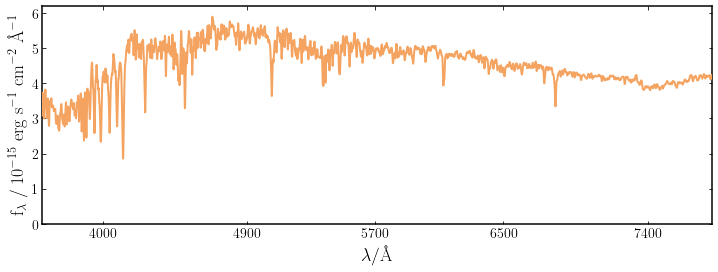

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [5]:
# create exponential decay model to be fitted
exp = {}
exp['age'] = 9
exp['tau'] = 4
exp['massformed'] = 11
exp['metallicity'] = 1.0

model_comp = {}
model_comp['exponential'] = exp
model_comp['redshift'] = 0.04
model_comp['veldisp'] = 100

exp_model = pipes.model_galaxy(model_comp, spec_wavs=obs_wavs)

exp_model.sfh.plot()
exp_model.plot()

In [6]:
# set up fit instructions
fit_exp = {}
fit_exp['age'] = (0,14)
fit_exp['tau'] = (0.3,10)
fit_exp['massformed'] = (6,13)
fit_exp['metallicity'] = (0.01,2.5)

fit_instructions = {}
fit_instructions['exponential'] = fit_exp
fit_instructions['redshift'] = (0.04-0.02*0.04, 0.04+0.02*0.04)
fit_instructions["veldisp"] = (0.1, 4000.)
fit_instructions["veldisp_prior"] = "log_10"
print(fit_instructions)

{'exponential': {'age': (0, 14), 'tau': (0.3, 10), 'massformed': (6, 13), 'metallicity': (0.01, 2.5)}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


In [51]:
# function to load spectrum from model galaxy into fitting
class fitting_obj:
    def __init__(self, model, SNR):
        self.model = model
        self.SNR = SNR
    def load_mock_spec(self, ID):
        spectrum = self.model.spectrum.copy()
        spectrum_noise = spectrum[:,1]/self.SNR
        spectrum = np.hstack([spectrum, np.expand_dims(spectrum_noise, axis=1)])
        return spectrum
    
ID = 'exp_mock_model'
runID = 'exp_mock_model_recovery_bin_by_1_4340_Rspec_veldispOn'
exp_fit = fitting_obj(exp_model, 15)
galaxy = pipes.galaxy(ID, exp_fit.load_mock_spec, photometry_exists=False)
pipes.config.Rspec = 4340
fit = pipes.fit(galaxy, fit_instructions, run=runID)
#fit.fit(verbose=False)
fit._print_results()


Results loaded from pipes/posterior/exp_mock_model_recovery_bin_by_1_4340_Rspec_veldispOn/exp_mock_model.h5

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
exponential:age                7.576      8.890     11.017
exponential:massformed        10.968     10.999     11.045
exponential:metallicity        0.941      1.041      1.202
exponential:tau                3.172      3.937      5.291
redshift                       0.040      0.040      0.040
veldisp                       95.534    100.076    104.687




In [29]:
def plot_spec2(fit, ID, runID, save=True):

    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 10,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    get_advanced_quantities(fit)

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    #fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1, label='data')
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)
    ind_bestfit = np.argmax(fit.results["lnlike"][fit.posterior.indices])
    bestfit_spec = fit.posterior.samples["spectrum"][ind_bestfit]
    ax1.plot(fit.galaxy.spectrum[:,0], bestfit_spec*10**-y_scale, color='k', lw=1, zorder=0,
             label='max like')

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(fit.galaxy.spectrum[:,1]-post_median)*10**-y_scale, 
             color="sandybrown", alpha=1.0, label='data-median posterior', zorder=10)
    ax3.plot(fit.galaxy.spectrum[:,0],(fit.galaxy.spectrum[:,1]-bestfit_spec)*10**-y_scale, 
             color="black", lw=1, alpha=0.5, label='data-max like')
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    
    ax1.legend()
    ax3.legend(loc='upper right')
    plt.show()

def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID, plot_mean=False,
             ninty_region=False, samples=0, save=True):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value
    
    #identify SFH component used
    pipes_sfh_funcs = dir(pipes.models.star_formation_history)
    for key in fit.fit_instructions:
        if key in pipes_sfh_funcs:
            SFH_comp = key
            break

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    #median_sfh = np.median(post_sfh,axis=0)
    mean_sfh = np.mean(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    #post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    #c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',10**np.median(fit.posterior.samples[SFH_comp+":massformed"])
          /model_m_total,'of total mass formed.')
    print(np.median(fit.posterior.samples[SFH_comp+":massformed"]), np.log10(model_m_total))

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = np.zeros([len(mass_percentiles), fit.posterior.n_samples])
    c_sfh_samples = []
    for i,sfh_sample in enumerate(fit.posterior.samples['sfh']):
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs[:,i] = np.interp(mass_percentiles, c_sfh_, post_ages_int)
    txs = txs/10**9
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    c_sfh_mean = np.mean(c_sfh_samples, axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False, zorder=9)
    if plot_mean:
        ax[0].plot(post_ages, mean_sfh, color='k', ls='--', zorder=7)
    if ninty_region:
        ninty_sfh = np.percentile(post_sfh, (5,95), axis=0)
        ax[0].fill_between(post_ages, ninty_sfh[0], ninty_sfh[1], color='gray', 
                           alpha=0.3, zorder=6)
    ax[0].plot(model_ages, model_sfh, zorder=10)
    ylim = ax[0].get_ylim()

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5, zorder=1)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5,
                           zorder=1)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr ',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=9)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=8)
    if plot_mean:
        ax[1].plot(post_ages[::-1], c_sfh_mean, color='k', ls='--', zorder=6)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=7)
    if ninty_region:
        c_ninty_sfh = np.percentile(c_sfh_samples, (5,95), axis=0)
        ax[1].fill_between(post_ages[::-1], c_ninty_sfh[0], c_ninty_sfh[1], color='gray', 
                           alpha=0.3, zorder=5)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=10)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    if samples > 0:
        samp_ind = np.random.randint(fit.posterior.n_samples, size=samples)
        for samp_i in samp_ind:
            ax[0].plot(post_ages, fit.posterior.samples['sfh'][samp_i], color='black', alpha=0.3, ls='--',
                       zorder=5)
            ax[1].plot(post_ages[::-1], c_sfh_samples[samp_i], color='black', alpha=0.3, ls='--', zorder=5)
    
    if save:
        fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax

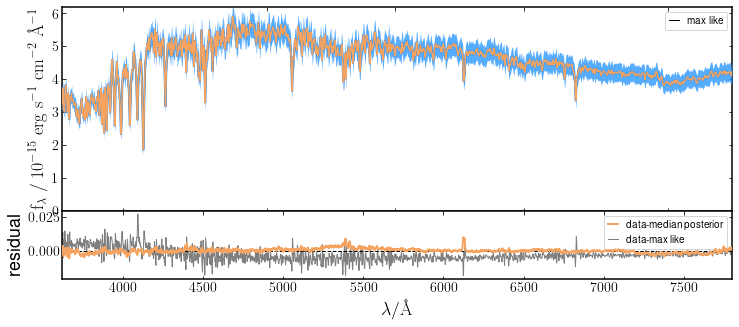

In [30]:
plot_spec2(fit, ID, runID)

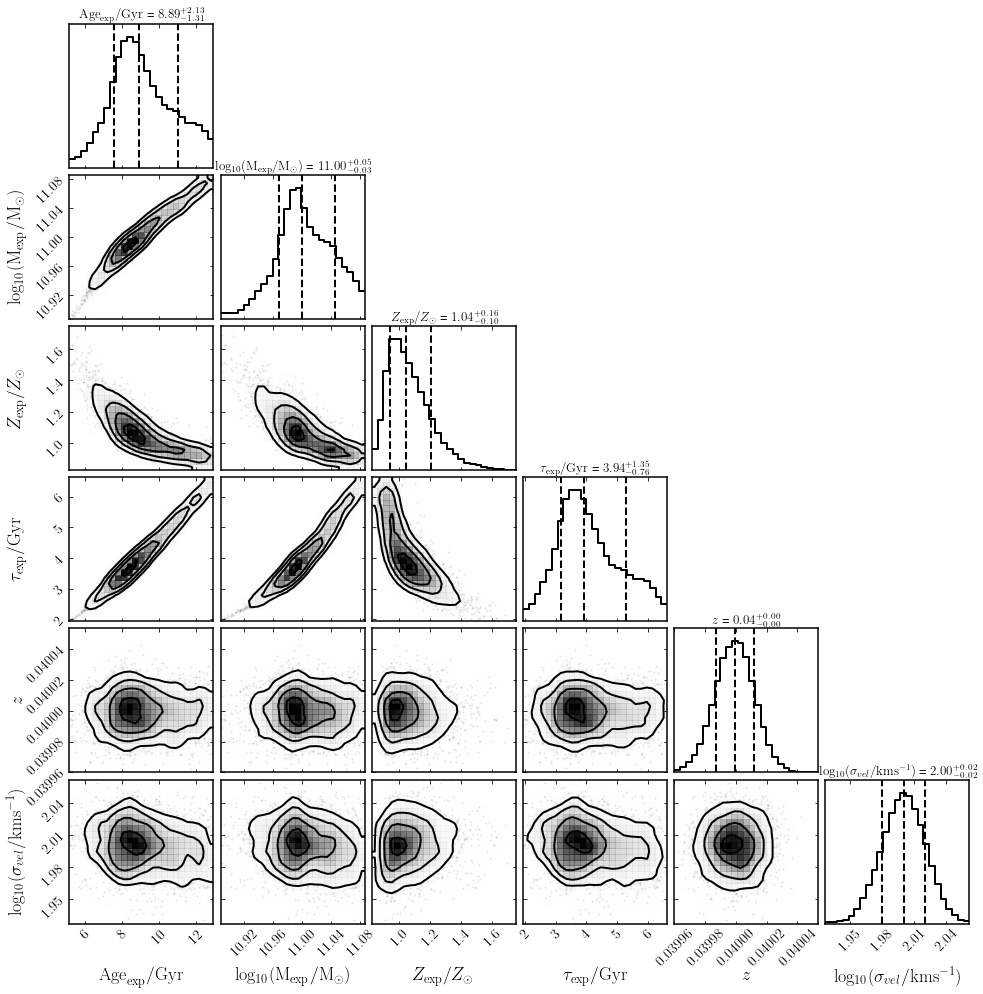

In [17]:
fit.plot_corner(save=True)

only recovered 0.9972766376194018 of total mass formed.
10.998804612375087 10.999988967075721


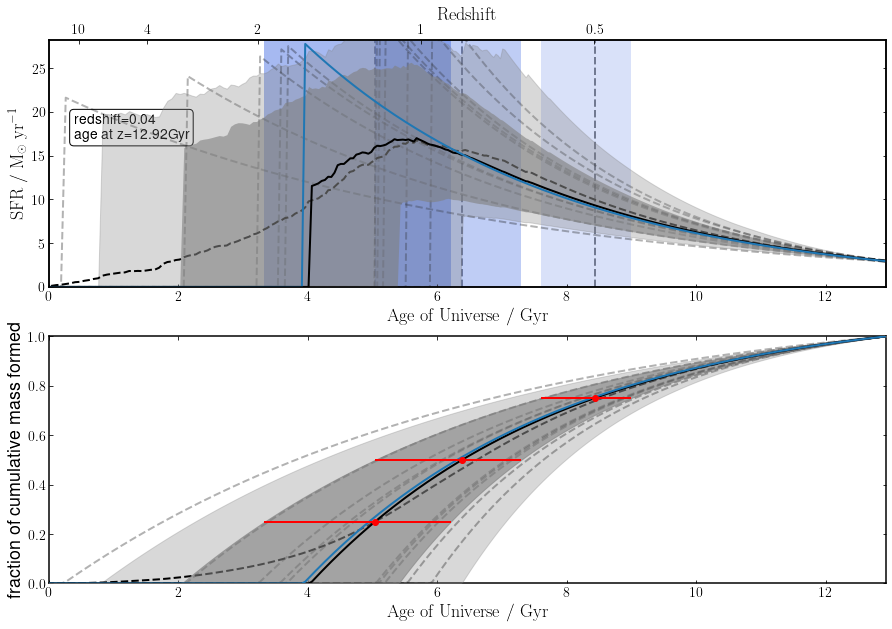

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [22]:
plot_sfh(fit, exp_model.sfh.ages*10**-9, exp_model.sfh.sfh,
         ID, runID, samples=10, plot_mean=True, ninty_region=True)

In [32]:
# violin plot
samps = fit.posterior.samples.copy()
for key in ['sfh', 'spectrum', 'mass_weighted_age', 'tform', 'tquench', 
            'spectrum_full', 'uvj', 'formed_mass']:
    samps.pop(key, None)
samps_df = pd.DataFrame(samps)
for col in samps_df.columns:
    if ':' in col:
        samps_df.rename(columns={col: col.split(':')[1]}, inplace=True)
samps_df

,age,massformed,metallicity,tau,nsfr,redshift,sfr,ssfr,stellar_mass,veldisp
0,8.672322,10.994130,1.032742,3.804029,-0.407912,0.039988,2.984100,-10.214974,10.689787,104.056836
1,10.456597,11.034917,0.973518,4.948188,-0.438950,0.040015,3.051931,-10.237854,10.722429,98.969573
2,6.182290,10.926246,1.366816,2.415900,-0.339341,0.039999,2.988857,-10.157357,10.632862,103.956741
3,8.489869,10.994124,1.158540,3.731213,-0.395348,0.040031,3.071786,-10.202197,10.689588,94.986436
4,8.179886,10.982960,1.025704,3.491341,-0.401628,0.039997,2.950745,-10.210550,10.680482,97.089506
...,...,...,...,...,...,...,...,...,...,...
495,9.505763,11.019993,1.094193,4.365931,-0.418904,0.040004,3.088100,-10.221347,10.711038,106.201579
496,10.494379,11.035195,0.955010,4.917689,-0.448723,0.039974,2.985805,-10.246757,10.721818,96.226232
497,7.052837,10.952609,1.392851,2.957492,-0.346896,0.039989,3.121110,-10.160359,10.654668,95.816346
498,9.116768,11.001209,0.974225,4.042347,-0.418489,0.040002,2.960204,-10.223269,10.694591,98.361413


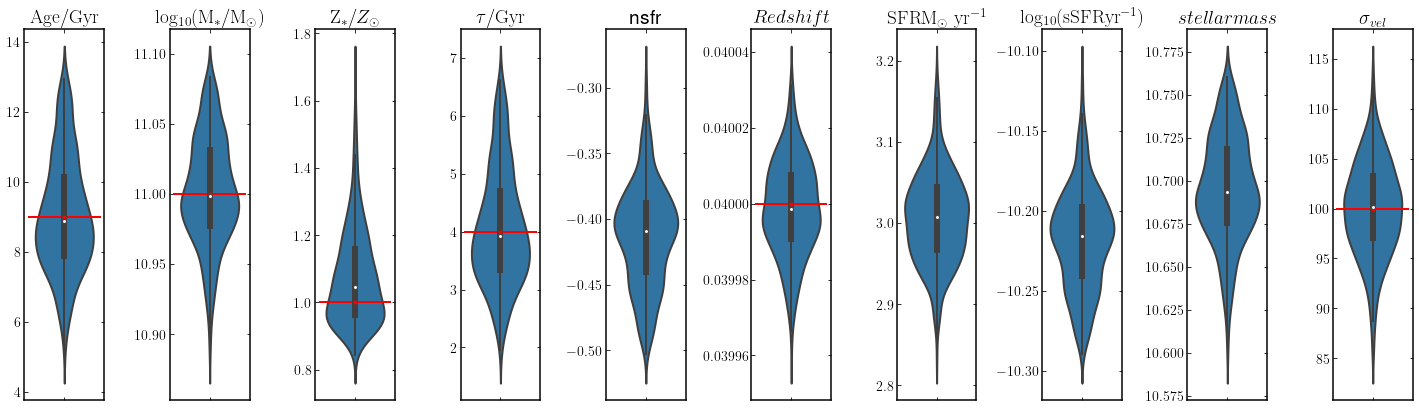

In [47]:
ylabels = {
    "age": "\\mathrm{Age}/\\mathrm{Gyr}",
    "tau": "\\tau/\\mathrm{Gyr}",
    "alpha1": "\\alpha_1",
    "burstage": "\\mathrm{Burst\\ Age}/\\mathrm{Gyr}",
    "alpha2": "\\alpha_2",
    "fburst" : "\\mathrm{f_{burst}}",
    "massformed": "\\mathrm{log_{10}(M_*/M_{\\odot})}",
    "redshift": "Redshift",
    "veldisp": "\\sigma_{vel}",
    "stellar_mass": "stellar mass",
    "sfr": "\\mathrm{SFR}\\mathrm{M_\\odot\\ yr}^{-1}",
    "ssfr": "\\mathrm{log_{10}(sSFR\\mathrm{yr}^{-1})}",
    "metallicity": "\\mathrm{Z_*}/Z_{\\odot}",
    "metallicity_old": "\\mathrm{Z_{old}}/Z_{\\odot}",
    "metallicity_burst": "\\mathrm{Z_{burst}}/Z_{\\odot}",
    "metallicity_slope": "\\mathrm{Z_{slope}}/Z_{\\odot}\\ Gyr^{-1}"
          }

fig, ax = plt.subplots(1,len(samps_df.columns), figsize=[20,6])
for i,param in enumerate(samps_df.columns):
    sns.violinplot(y=samps_df[param], ax=ax[i])
    ax[i].set_ylabel('')
    if param in ylabels:
        ax[i].set_title('$'+ylabels[param]+'$')
    else: ax[i].set_title(param)
    if param in model_comp:
        ax[i].errorbar([0], [model_comp[param]], xerr=0.5, ls='', marker='.', color='r')
    elif param in model_comp['exponential']:
        ax[i].errorbar([0], [model_comp['exponential'][param]], xerr=0.5, ls='', marker='.', color='r')
        
plt.tight_layout()
plt.show()